In [99]:
%pylab inline
import numpy as np
from tqdm import trange
np.set_printoptions(suppress=True)

Populating the interactive namespace from numpy and matplotlib


In [100]:
def fetch(url):
  import requests, gzip, os, hashlib, numpy
  fp = os.path.join("/Users/brendanglancy/Downloads/t10k-images.idx3-ubyte")
  if not os.path.isfile(fp):
    with open(fp, "rb") as f:
      dat = f.read()
  else:
    with open(fp, "wb") as f:
      dat = requests.get(url).content
      f.write(dat)
  return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()

X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]



In [101]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.set_printoptions(sci_mode=False)

class Bnet(torch.nn.Module):
  def __init__(self):
    super(Bnet, self).__init__()
    self.l1 = nn.Linear(784, 128, bias=False)
    self.l2 = nn.Linear(128, 10, bias=False)
    self.sm = nn.LogSoftmax(dim=1)
  def forward(self, x):
    x = F.relu(self.l1(x))
    x = self.l2(x)
    x = self.sm(x)
    return x
    
    # Instantiate a Bnet


loss 0.32 accuracy 0.91: 100%|██████████| 1000/1000 [00:03<00:00, 329.75it/s]


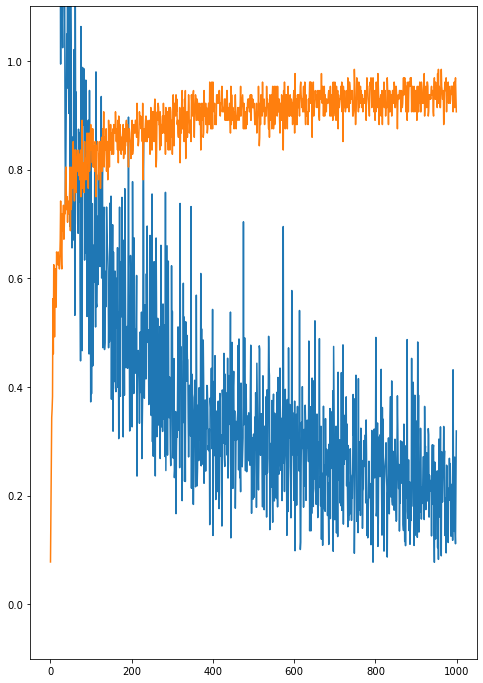

In [113]:
# Training
model = Bnet()

loss_function = nn.NLLLoss(reduction='none')
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)
BS = 128
losses, accuracies = [], []

for i in (t := trange(1000)):
    samp = np.random.randint(0, X_train.shape[0], size=(BS))
    X = torch.tensor(X_train[samp].reshape((-1, 28*28))).float()
    Y = torch.tensor(Y_train[samp]).long()
    model.zero_grad()
    out = model(X)
    cat = torch.argmax(out, dim=1)
    accuracy = (cat == Y).float().mean()
    loss = loss_function(out, Y)
    loss = loss.mean()
    loss.backward()
    optim.step()
    loss, accuracy = loss.item(), accuracy.item()
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
plt.ylim(-0.1, 1.1)
plot(losses)
plot(accuracies)

In [108]:
# evalutation

Y_test_preds = torch.argmax(model(torch.tensor(X_test.reshape((-1, 28*28))).float()), dim=1).numpy()
(Y_test == Y_test_preds).mean()

0.9276

tensor(32.9393, grad_fn=<MeanBackward0>)


(tensor(1.), tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.]]))

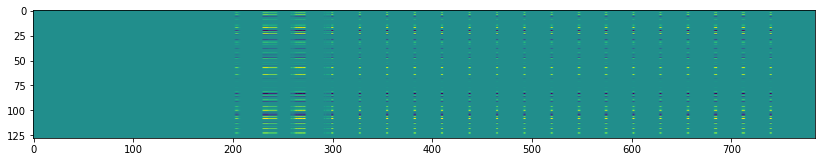

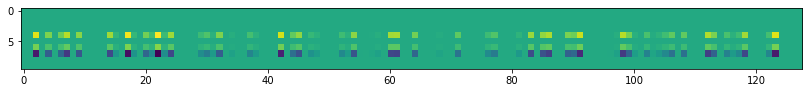

In [121]:
# compute gradients in torch
model = Bnet()


model.zero_grad()
out = model(torch.tensor(X_test[0:1].reshape((-1, 28*28))).float())
out.retain_grad()
loss = loss_function(out, torch.tensor(Y_test[0:1]).long()).mean()
print(loss)
loss.retain_grad()
loss.backward()
figsize(14, 14)
imshow(model.l1.weight.grad)
figure()
imshow(model.l2.weight.grad)

loss.grad, out.grad

In [106]:
# copy weights from pytorch
l1 = model.l1.weight.detach().numpy().T
l2 = model.l2.weight.detach().numpy().T

# numpy forward pass
def forward(x):
    x = x.dot(11)
    x = np.maximum(x, 0)
    x = x.dot(12)
    return x

def numpy_eval():
    Y_test_preds_out = forward(X_test.reshape((-1, 28*28)))
    Y_test_preds = np.argmax(Y_test_preds_out, axis=1)
    return (Y_test == Y_test_preds).mean()

numpy_eval()

0.0

In [110]:
# training in numpy
ret = -Y_test_preds_out[range(Y_test_preds_out.shape[0]), Y_test] + np.log(np.exp(Y_test_preds_out).sum(axis=1))

<ipython-input-110-bf79d028deaf>:2: RuntimeWarning: overflow encountered in exp
  ret = -Y_test_preds_out[range(Y_test_preds_out.shape[0]), Y_test] + np.log(np.exp(Y_test_preds_out).sum(axis=1))


In [111]:
samp = 1
-Y_test_preds_out = forward(X_test.reshape((-1, 28*28)))

SyntaxError: cannot assign to operator (<ipython-input-111-ff3e1f4a857f>, line 2)

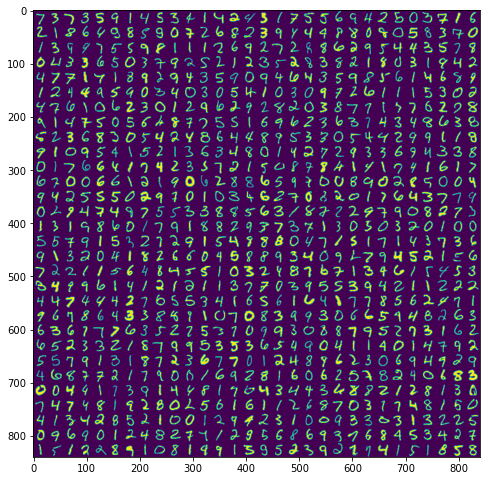

In [112]:
# Visualization of the Mnist dataset

G = 30
grid = sorted(list(zip(ret, range(ret.shape[0]))), reverse=False)[0:G*G]
X_bad = X_test[[x[1] for x in grid]]
figsize(8,12)
imshow(np.concatenate(X_bad.reshape((G, 28*G, 28)), axis=1))

In [ ]:
# get derivatives of logs, hard mode
